In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'

In [4]:
df = pd.read_csv("data/mcc18_test_data.csv")

df['D'] = 0.6

df['Pi'] = df['Ii'] * df['Vi']
df['Po'] = df['Io'] * df['Vo']

df['Eff'] = df['Po'] / df['Pi']
df['Eff'] = df['Eff'].fillna(value=0)

df['M'] = df['D'] / (1 - df['D'])
df['M_I'] = df['Ii'] / df['Io']
df['M_V'] = df['Vo'] / df['Vi']

df['Vo_hat'] = df['Vi'] * df['M']
df['Io_hat'] = df['Ii'] / df['M']

df['Eff_Vo_hat'] = df['Vo_hat'] / df['Vo']
df['Eff_Io_hat'] = df['Io_hat'] / df['Io']
df['Eff_hat'] = (df['Eff_Vo_hat'] * df['Eff_Io_hat'])

print('Mean Eff:', df[1:]['Eff'].mean())
print('Mean Eff Vo_hat:', df[1:]['Eff_Vo_hat'].mean())
print('Mean Eff Io_hat:', df[1:]['Eff_Io_hat'].mean())
print('Mean Eff hat:', df[1:]['Eff_hat'].mean())
print('Mean M:', df[1:]['M'].mean())
print('Mean M I:', df[1:]['M_I'].mean())
print('Mean M V:', df[1:]['M_V'].mean())


Mean Eff: 0.9258417569467561
Mean Eff Vo_hat: 1.117913983426126
Mean Eff Io_hat: 0.9663501776462632
Mean Eff hat: 1.0802670100867544
Mean M: 1.4999999999999998
Mean M I: 1.4495252664693945
Mean M V: 1.3420063848165489


0.9258417569467561


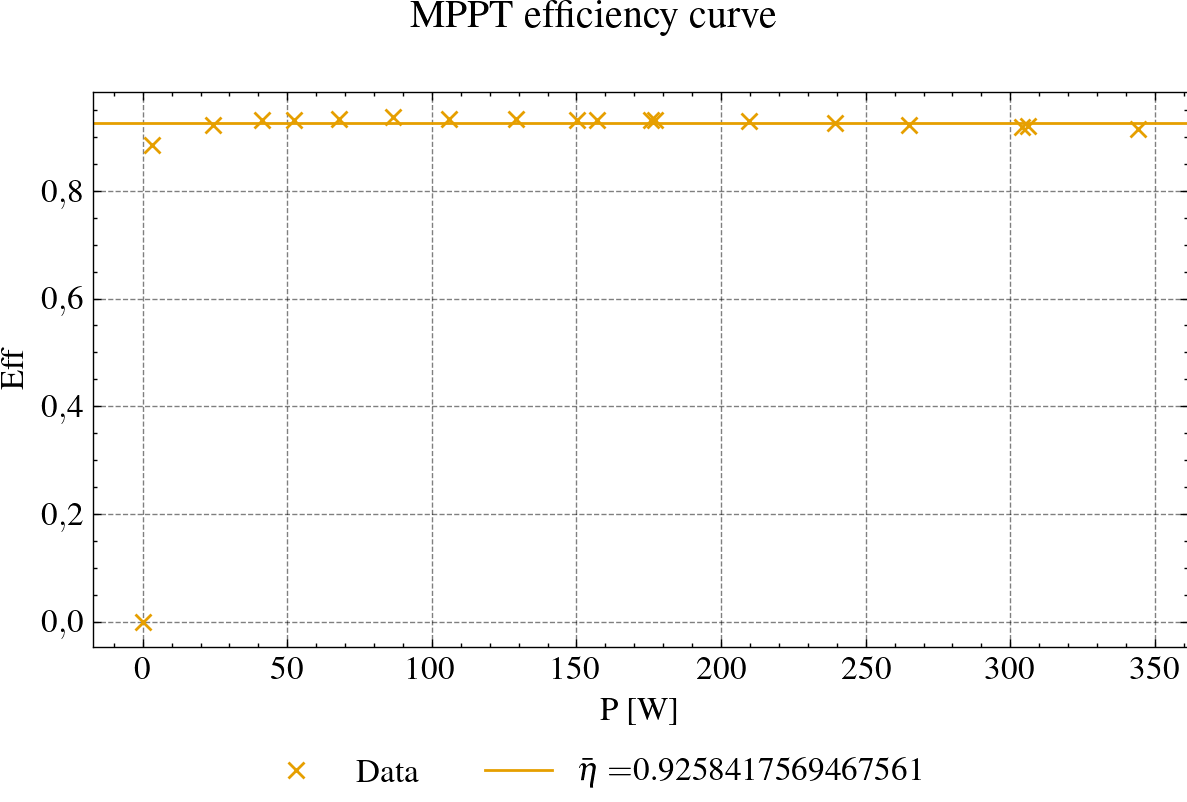

In [64]:
eff_mean = df['Eff'].to_numpy()[1:].mean()
print(eff_mean)

# Plot the original data and the fitted curve
title_en = 'MPPT efficiency curve'
title_ptg = 'Curva de eficiência do MPPT'
filename = f'{latex_img_path}/mppt_p_outwer_vs_eff_mean.pdf'

plt.figure()

plt.plot(df['Pi'], df['Eff'], 'x', label='Data')
plt.axhline(eff_mean, label=r'$\bar{\eta} = $' + str(eff_mean))
plt.xlabel('P [W]')
plt.ylabel('Eff')

fig_save_and_show(filename, title_ptg, title_en, ncol=2)

/tmp/ipykernel_211015/54262694.py:8: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b/x) + c*np.exp(-d/x)


[ 9.34665153e-01  1.69793545e-01 -1.56199844e-01  7.17453924e+02]


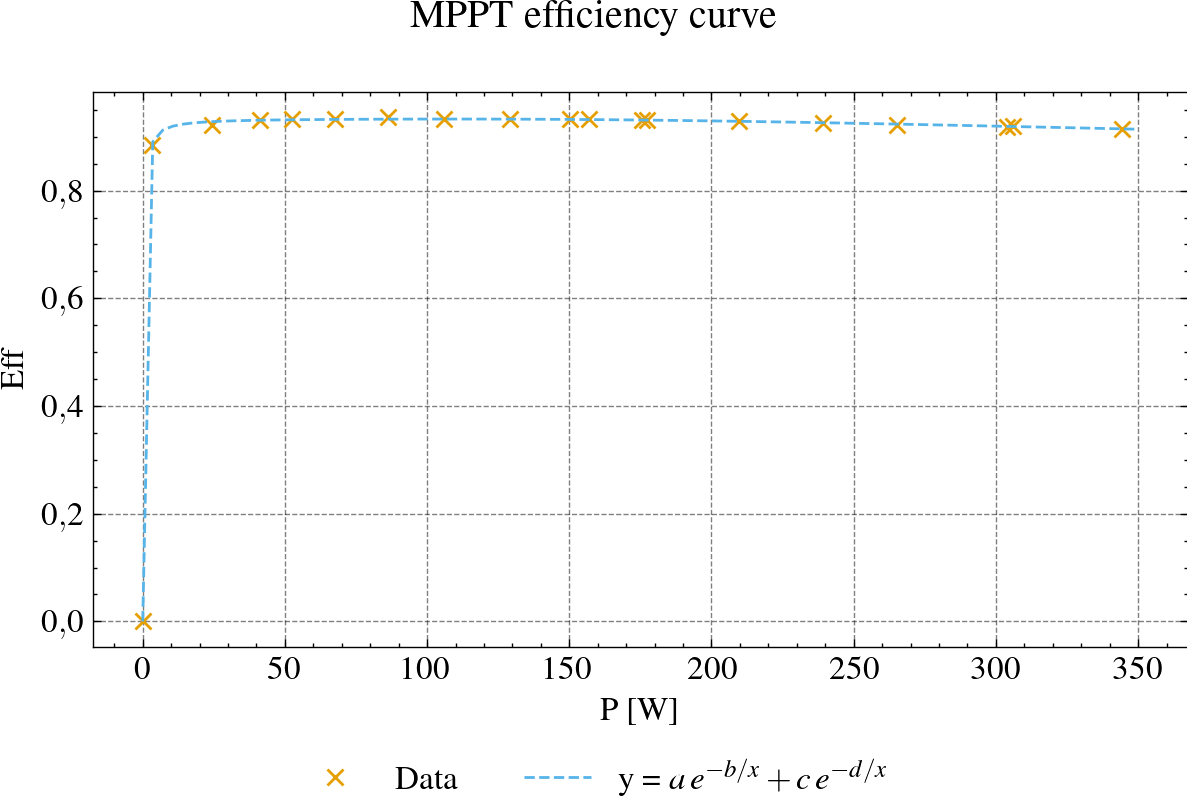

In [ ]:
from scipy.optimize import curve_fit


# Define the function to use for curve fitting
def func(x, a, b, c, d):
    # Clipping because zero is a pole for this model
    x = x.clip(min=1e-6)
    return a*np.exp(-b/x) + c*np.exp(-d/x)


# Fit the curve to the data
popt, _ = curve_fit(func, df['Pi'].to_numpy(), df['Eff'].to_numpy())
print(popt)

pi = np.linspace(0, 350, 100)

# Plot the original data and the fitted curve
title_en = 'MPPT efficiency curve'
title_ptg = 'Curva de eficiência do MPPT'
filename = f'{latex_img_path}/mppt_p_outwer_vs_eff_fit.pdf'

plt.figure()

plt.plot(df['Pi'], df['Eff'], 'x', label='Data')
plt.plot(pi, func(pi, *popt), label=r'y = $a\,e^{-b/x} + c\,e^{-d/x}$')
plt.xlabel('P [W]')
plt.ylabel('Eff')

fig_save_and_show(filename, title_ptg, title_en, ncol=2)

{0.0: 0.0, 4.040404040404041: 0.8962007482830393, 8.080808080808081: 0.9152309048992936, 12.121212121212121: 0.9216636684636083, 16.161616161616163: 0.9248969853574197, 20.202020202020204: 0.9268424175417572, 24.242424242424242: 0.9281416451504616, 28.282828282828284: 0.9290707797589286, 32.323232323232325: 0.9297682410280973, 36.36363636363637: 0.9303110725129525, 40.40404040404041: 0.930745563574853, 44.44444444444445: 0.9311011971245723, 48.484848484848484: 0.9313976291274028, 52.525252525252526: 0.9316484424345465, 56.56565656565657: 0.9318632836025772, 60.60606060606061: 0.9320491370525987, 64.64646464646465: 0.9322111164828274, 68.68686868686869: 0.9323529761677731, 72.72727272727273: 0.9324774550064384, 76.76767676767678: 0.9325865180866566, 80.80808080808082: 0.9326815336323878, 84.84848484848486: 0.9327634077242403, 88.8888888888889: 0.9328326901513351, 92.92929292929294: 0.9328896594665044, 96.96969696969697: 0.9329343922394913, 101.01010101010101: 0.9329668197286676, 105.050

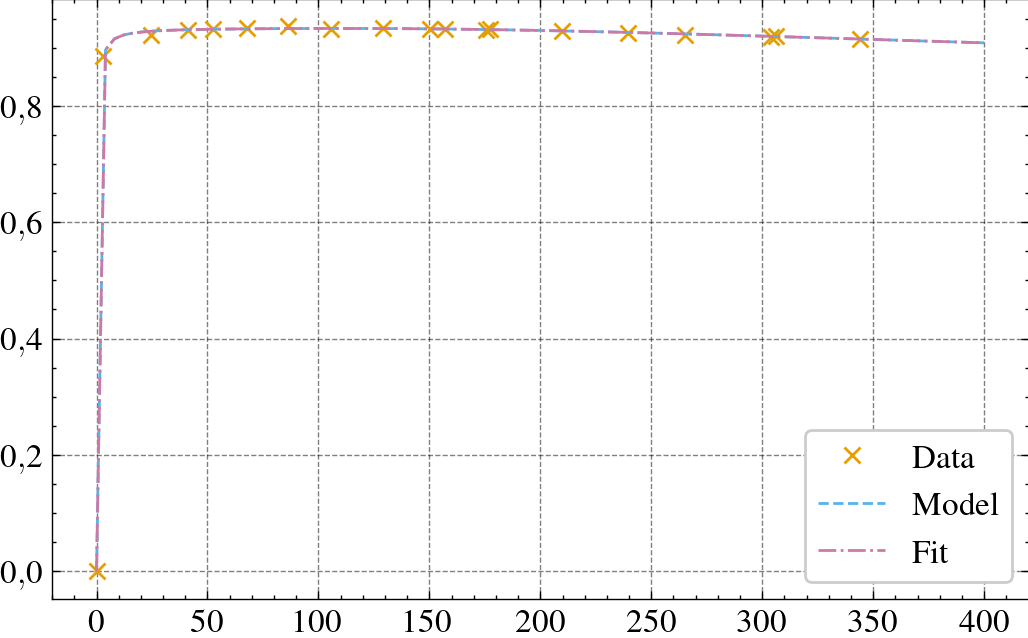

In [14]:
import bisect

def interpolate(lookup_table, value):
    sorted_keys = sorted(lookup_table.keys())

    # Check if value is below the lowest key
    if value < sorted_keys[0]:
        return lookup_table[sorted_keys[0]]

    # Check if value is above the highest key
    if value > sorted_keys[-1]:
        return lookup_table[sorted_keys[-1]]

    # Find the nearest lower and higher keys using bisect_left
    index = bisect.bisect_left(sorted_keys, value)
    if sorted_keys[index] == value:
        return lookup_table[value]

    low = sorted_keys[index - 1]
    high = sorted_keys[index]
    low_value = lookup_table[low]
    high_value = lookup_table[high]
    interpolation_ratio = (value - low) / (high - low)
    interpolated_value = low_value + (high_value - low_value) * interpolation_ratio
    return interpolated_value


pi = np.linspace(0, 400, 100)

# Use previous model
df2 = pd.DataFrame()
df2['Pi'] = pi
df2['Eff'] = func(pi, *popt)

# Create a LUT from previous model
eff_lut = {pi: eff for (pi,eff) in df2[['Pi', 'Eff']].to_numpy()}
eff = np.fromiter((interpolate(eff_lut, pi) for pi in pi), pi.dtype)
print(eff_lut)

# Plot the original data and the fitted curve
plt.plot(df['Pi'], df['Eff'], 'x', label='Data')
plt.plot(df2['Pi'], df2['Eff'], label='Model')
plt.plot(pi, eff, label='Fit')
plt.legend()
plt.show()